In [1]:
#SVM
from skimage.feature import hog
from skimage.transform import pyramid_gaussian
import joblib
from skimage import color
from imutils.object_detection import non_max_suppression
import imutils
import numpy as np
import cv2
import os
import glob

#Define HOG Parameters
# change them if necessary to orientations = 8, pixels per cell = (16,16), cells per block to (1,1) for weaker HOG
orientations = 9
pixels_per_cell = (8, 8)
cells_per_block = (2, 2)
threshold = .3

# define the sliding window:
def sliding_window(image, stepSize, windowSize):# image is the input, step size is the no.of pixels needed to skip and windowSize is the size of the actual window
    # slide a window across the image
    for y in range(0, image.shape[0], stepSize):# this line and the line below actually defines the sliding part and loops over the x and y coordinates
        for x in range(0, image.shape[1], stepSize):
            # yield the current window
            yield (x, y, image[y: y + windowSize[1], x:x + windowSize[0]])
#%%
# Upload the saved svm model:
model = joblib.load('C:/Users/INDIAN/Downloads/Speed Bump Detection System1/Speed Bump Detection System/SVM/model_name.npy')

# Test the trained classifier on an image below!
scale = 0
detections = []
# read the image you want to detect the object in:#
img= cv2.imread("C:/Users/INDIAN/Downloads/Speed Bump Detection System1/Speed Bump Detection System/SVM/test/23.png")

# Try it with image resized if the image is too big
img= cv2.resize(img,(300,200)) # can change the size to default by commenting this code out our put in a random number



#img= cv2.resize(img,(64,128)) # can change the size to default by commenting this code out our put in a random number


# defining the size of the sliding window (has to be, same as the size of the image in the training data)
(winW, winH)= (300,200)
windowSize=(winW,winH)
downscale=1.5
# Apply sliding window:
for resized in pyramid_gaussian(img, downscale=1.5): # loop over each layer of the image that you take!
    # loop over the sliding window for each layer of the pyramid
    for (x,y,window) in sliding_window(resized, stepSize=10, windowSize=(winW,winH)):
        # if the window does not meet our desired window size, ignore it!
        if window.shape[0] != winH or window.shape[1] !=winW: # ensure the sliding window has met the minimum size requirement
            continue
        window=color.rgb2gray(window)
        fds = hog(window, orientations, pixels_per_cell, cells_per_block, block_norm='L2')  # extract HOG features from the window captured
        fds = fds.reshape(1, -1) # re shape the image to make a silouhette of hog
        pred = model.predict(fds) # use the SVM model to make a prediction on the HOG features extracted from the window
        
        if pred == 1:
            if model.decision_function(fds) > 0.6:  # set a threshold value for the SVM prediction i.e. only firm the predictions above probability of 0.6
                print("Detection:: Location -> ({}, {})".format(x, y))
                print("Scale ->  {} | Confidence Score {} \n".format(scale,model.decision_function(fds)))
                detections.append((int(x * (downscale**scale)), int(y * (downscale**scale)), model.decision_function(fds),
                                   int(windowSize[0]*(downscale**scale)), # create a list of all the predictions found
                                      int(windowSize[1]*(downscale**scale))))
    scale+=1
    
clone = resized.copy()
for (x_tl, y_tl, _, w, h) in detections:
    cv2.rectangle(img, (x_tl, y_tl), (x_tl + w, y_tl + h), (0, 0, 255), thickness = 2)
rects = np.array([[x, y, x + w, y + h] for (x, y, _, w, h) in detections]) # do nms on the detected bounding boxes
sc = [score[0] for (x, y, score, w, h) in detections]
print("detection confidence score: ", sc)
sc = np.array(sc)
pick = non_max_suppression(rects, probs = sc, overlapThresh = 0.3)

# the peice of code above creates a raw bounding box prior to using NMS
# the code below creates a bounding box after using nms on the detections
# you can choose which one you want to visualise, as you deem fit... simply use the following function:
# cv2.imshow in this right place (since python is procedural it will go through the code line by line).
        
for (xA, yA, xB, yB) in pick:
    cv2.rectangle(img, (xA, yA), (xB, yB), (0,255,0), 2)
    cv2.putText(img, "Speed Bump Spotted", (0,30), cv2.FONT_HERSHEY_SIMPLEX,   0.75, (0, 255, 0), 2)
    
cv2.imshow("SVM Output", img)
#### Save the images below
cv2.waitKey(0)
 
# It is for removing/deleting created GUI window from screen
# and memory
cv2.destroyAllWindows()


Detection:: Location -> (0, 0)
Scale ->  0 | Confidence Score [0.99609845] 

detection confidence score:  [0.9960984454899726]


C:\Users\INDIAN\anaconda3\lib\site-packages\skimage\_shared\utils.py:348: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  return func(*args, **kwargs)


In [2]:
#Adaptive Threshold
import cv2
cascPathface = "C:/Users/INDIAN/Downloads/Speed Bump Detection System1/Speed Bump Detection System/Adaptive Threshold/classifier/cascade.xml"

# load the harcaascade in the cascade classifier
faceCascade = cv2.CascadeClassifier(cascPathface)
img = cv2.imread("C:/Users/INDIAN/Downloads/Speed Bump Detection System1/Speed Bump Detection System/Adaptive Threshold/test/23.png", cv2.IMREAD_COLOR)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
th3 = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
cartoons = faceCascade.detectMultiScale(th3,
                                     scaleFactor=1.1,
                                     minNeighbors=5,
                                     minSize=(60, 60),
                                     flags=cv2.CASCADE_SCALE_IMAGE)
for(x,y,w,h) in cartoons:
    area=w*h
    cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)
    cv2.putText(img, "Speed Bump Spotted", (x, y), cv2.FONT_HERSHEY_SIMPLEX,
             0.75, (255, 0, 0), 2)
cv2.imshow("image", img)
cv2.waitKey(0)
 
# It is for removing/deleting created GUI window from screen
# and memory
cv2.destroyAllWindows()

In [3]:
#OTSU Threshold
import cv2
cascPathface = "C:/Users/INDIAN/Downloads/Speed Bump Detection System1/Speed Bump Detection System/OTSU Threshold/classifier/cascade.xml"

# load the harcaascade in the cascade classifier
faceCascade = cv2.CascadeClassifier(cascPathface)
img = cv2.imread("C:/Users/INDIAN/Downloads/Speed Bump Detection System1/Speed Bump Detection System/OTSU Threshold/test/23.png", cv2.IMREAD_COLOR)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret2,th2 = cv2.threshold(gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
cartoons = faceCascade.detectMultiScale(th2,
                                     scaleFactor=1.1,
                                     minNeighbors=5,
                                     minSize=(60, 60),
                                     flags=cv2.CASCADE_SCALE_IMAGE)
for(x,y,w,h) in cartoons:
    area=w*h
    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.putText(img, "Speed Bump Spotted", (x, y), cv2.FONT_HERSHEY_SIMPLEX,
             0.75, (0, 255, 0), 2)
cv2.imshow("image", img)
cv2.waitKey(0)
 
# It is for removing/deleting created GUI window from screen
# and memory
cv2.destroyAllWindows()

C:\Users\INDIAN\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\INDIAN\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


['Speed Bump', 'Speed Bump', 'Speed Bump', 'Speed Bump', 'Speed Bump', 'Speed Bump', 'Speed Bump', 'Speed Bump', 'Speed Bump', 'Speed Bump', 'Speed Bump', 'Speed Bump', 'Speed Bump', 'Speed Bump', 'Speed Bump']
tensor([[258.7712, 117.4626, 729.3303, 174.7288],
        [400.8199, 128.9355, 816.0000, 179.9787],
        [144.6577, 123.1138, 596.8815, 179.4832],
        [  0.0000, 121.7003, 461.7066, 172.5143],
        [172.7332,  98.7487, 816.0000, 201.4705],
        [ 91.8286, 140.1454, 540.2110, 190.0244],
        [295.6911, 140.1142, 728.7510, 190.2828],
        [  9.2901, 147.7079, 403.2510, 196.5555],
        [ 53.3747,  95.6986, 592.4600, 158.9074],
        [508.8022, 155.0427, 816.0000, 191.3461],
        [441.4285, 150.9250, 816.0000, 218.2807],
        [  0.0000,  78.3655, 492.0919, 184.4532],
        [149.3195, 151.4867, 456.6590, 183.8035],
        [244.7170, 144.6449, 364.7038, 191.0529],
        [645.6226, 150.6106, 816.0000, 197.0480]])
tensor([0.4248, 0.4068, 0.3933, 0.3298

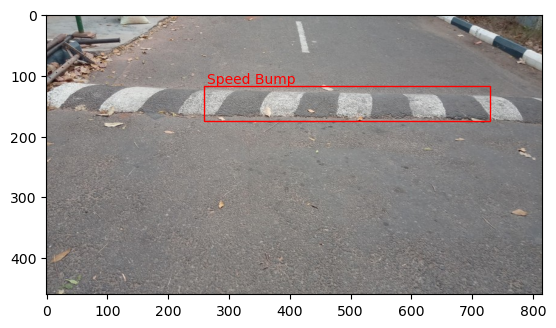

In [4]:
#RESNET
from detecto import core, utils, visualize
model = core.Model.load('C:/Users/INDIAN/Downloads/Speed Bump Detection System1/Speed Bump Detection System/RESNET/model_weights.pth', ['Speed Bump'])
image = utils.read_image('C:/Users/INDIAN/Downloads/Speed Bump Detection System1/Speed Bump Detection System/RESNET/images/138.png')
predictions = model.predict(image)

# predictions format: (labels, boxes, scores)
labels, boxes, scores = predictions

# ['alien', 'bat', 'bat']
print(labels) 

#           xmin       ymin       xmax       ymax
# tensor([[ 569.2125,  203.6702, 1003.4383,  658.1044],
#         [ 276.2478,  144.0074,  579.6044,  508.7444],
#         [ 277.2929,  162.6719,  627.9399,  511.9841]])
print(boxes)

# tensor([0.9952, 0.9837, 0.5153])
print(scores)

for i in range(0,len(scores)):
  if(scores[i]==max(scores)):
    visualize.show_labeled_image(image, boxes[i], labels[i])